In [27]:
!pip install pillow scikit-learn wcag-contrast-ratio

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Preparing metadata (setup.py) ... done
  Created wheel for wcag-contrast-ratio: filename=wcag_contrast_ratio-0.9-py3-none-any.whl size=2356 sha256=a1837c77e5e10b84ec4437c6cdb16f650f6186496f0c8e44deadcc35a229ddb3
  Stored in directory: /tmp/pip-ephem-wheel-cache-r6c59boc/wheels/8e/48/5b/ecf261abcba8a8678fca886fa08bb51a2d4d5bcfd35fa4201a
Successfully built wcag-contrast-ratio


(248, 242, 228)


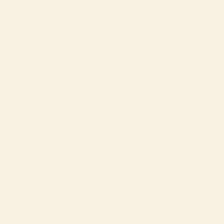

In [1]:
import collections

from PIL import Image


def get_colors_by_frequency(im):
    return collections.Counter(im.getdata())


if __name__ == "__main__":
    im = Image.open("maldives.jpg")
    colors = get_colors_by_frequency(im)
    top = colors.most_common(1)
    for i in top:
        img = Image.new("RGB", (224, 224), i[0])
        print(i[0])
        display(img)

In [2]:

import colorsys

from PIL import Image
from sklearn.cluster import KMeans
import wcag_contrast_ratio as contrast


def get_dominant_colours(path, *, count):
    """
    Return a list of the dominant RGB colours in the image at ``path``.

    :param path: Path to the image file.
    :param count: Number of dominant colours to find.

    """
    im = Image.open(path)

    # Resizing means less pixels to handle, so the *k*-means clustering converges
    # faster.  Small details are lost, but the main details will be preserved.
    im = im.resize((100, 100))

    # Ensure the image is RGB, and use RGB values in [0, 1] for consistency
    # with operations elsewhere.
    im = im.convert("RGB")
    colors = [(r / 255, g / 255, b / 255) for (r, g, b) in im.getdata()]

    return KMeans(n_clusters=count).fit(colors).cluster_centers_


def choose_tint_color(dominant_colors, background_color):
    # The minimum contrast ratio for text and background to meet WCAG AA
    # is 4.5:1, so discard any dominant colours with a lower contrast.
    sufficient_contrast_colors = [
        col
        for col in dominant_colors
        if contrast.rgb(col, background_color) >= 4.5
    ]

    # If none of the dominant colours meet WCAG AA with the background,
    # try again with black and white -- every colour in the RGB space
    # has a contrast ratio of 4.5:1 with at least one of these, so we'll
    # get a tint colour, even if it's not a good one.
    #
    # Note: you could modify the dominant colours until one of them
    # has sufficient contrast, but that's omitted here because it adds
    # a lot of complexity for a relatively unusual case.
    if not sufficient_contrast_colors:
        return choose_tint_color(
            dominant_colors=dominant_colors + [(0, 0, 0), (1, 1, 1)],
            background_color=background_color
        )

    # Of the colours with sufficient contrast, pick the one with the
    # closest brightness (in the HSV colour space) to the background
    # colour.  This means we don't get very dark or very light colours,
    # but more bright, vibrant colours.
    hsv_background = colorsys.rgb_to_hsv(*background_color)
    hsv_candidates = {
        tuple(rgb_col): colorsys.rgb_to_hsv(*rgb_col)
        for rgb_col in sufficient_contrast_colors
    }

    candidates_by_brightness_diff = {
        rgb_col: abs(hsv_col[2] - hsv_background[2])
        for rgb_col, hsv_col in hsv_candidates.items()
    }

    rgb_choice, _ = min(
        candidates_by_brightness_diff.items(),
        key=lambda t: t[1]
    )

    assert rgb_choice in dominant_colors
    return rgb_choice

In [3]:
dominant_colors = get_dominant_colours("maldives.jpg", count=5)
tint_color = choose_tint_color(dominant_colors, background_color=(0, 0, 0))

print(tint_color)
print("#%02x%02x%02x" % tuple(int(v * 255) for v in tint_color))

(0.674924142549229, 0.807667357231046, 0.8825705735869589)
#accde1


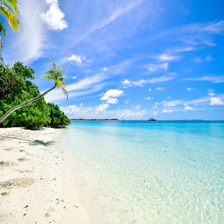

In [4]:
Image.open("maldives.jpg").resize((224,224))

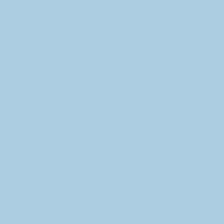

In [5]:
tint = Image.new("RGB", (224, 224), tuple([int(i*255) for i in tint_color]))
tint